## Step 1: Setup

Run the following cell to install the diffusers library as well as a few other requirements:

In [2]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

Then you need to install Git-LFS to upload your model checkpoints:

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

Finally, let's import the libraries we'll be using and define a few convenience functions which we'll use later in the notebook:

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MVP (Minimum Viable Pipeline)

The core API of 🤗 Diffusers is divided into three main components:
1. **Pipelines**: high-level classes designed to rapidly generate samples from popular trained diffusion models in a user-friendly fashion.
2. **Models**: popular architectures for training new diffusion models, *e.g.* [UNet](https://arxiv.org/abs/1505.04597).
3. **Schedulers**: various techniques for generating images from noise during *inference* as well as to generate noisy images for *training*.

Pipelines are great for end-users, but if you're here for this course we assume you want to know what is going on under the hood! So, over the rest of this notebook we're going to build our own pipeline capable of generating small butterfly pictures. Here's the final result in action:

## Step 2: Creating a training dataset



For this example, we'll use a dataset of images from the Hugging Face Hub. Specifically, [this collection of 1000 butterfly pictures](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset). This is a very small dataset, so we've also included commented out lines for a few larger options. If you'd prefer to use your own collection of images, you can also use the commented-out code example to load in pictures from a folder instead.

In [5]:
import random
import numpy as np
import time
import concurrent.futures
# @- black tiles, 1
# e- blue tiles, -1
# .- white tiles, 0

def create_numpy_arrays(grid_size,num_blue_tiles):

    def create_empty_grid():
        # Initialize grid with all white tiles ('.')
        grid = [['.' for _ in range(grid_size)] for _ in range(grid_size)]
        return grid

    # Function to print the grid
    def print_grid(grid):
        for row in grid:
            print(''.join(row))
        print()

    # Step 1: Place blue tiles ('e') sparsely across the grid
    def place_blue_tiles(grid, num_blue_tiles=num_blue_tiles):
        count = 0
        while count < num_blue_tiles:
            x, y = random.randint(0, grid_size - 1), random.randint(0, grid_size - 1)
            if grid[x][y] == '.':
                grid[x][y] = 'e'
                count += 1

    # Step 2: Place black tiles ('@') adjacent to blue tiles
    def place_black_tiles(grid):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for x in range(grid_size):
            for y in range(grid_size):
                if grid[x][y] == 'e':
                    shuffled_directions = random.sample(directions, len(directions))
                    for dx, dy in shuffled_directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < grid_size and 0 <= ny < grid_size and grid[nx][ny] == '.':
                            grid[nx][ny] = '@'
                            break

    # Modified Step 3: Ensure black tiles ('@') have at least two adjacent blue tiles and can have more
    def validate_black_tile_adjacency(grid):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        for x in range(grid_size):
            for y in range(grid_size):
                if grid[x][y] == '@':
                    blue_count = 0
                    # Randomly check directions to count adjacent blue tiles
                    shuffled_directions = random.sample(directions, len(directions))
                    for dx, dy in shuffled_directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < grid_size and 0 <= ny < grid_size and grid[nx][ny] == 'e':
                            blue_count += 1
                    while blue_count < 2:
                        for dx, dy in shuffled_directions:
                            nx, ny = x + dx, y + dy
                            if blue_count == 4:
                                break
                            if 0 <= nx < grid_size and 0 <= ny < grid_size and grid[nx][ny] == '.':
                                grid[nx][ny] = 'e'
                                blue_count += 1
                                if blue_count >= 2 and random.random() < 0.5:
                                    break

    # Step 4: Ensure all blue tiles are connected by non-black paths
    def validate_blue_connectivity(grid):
        visited = [[False for _ in range(grid_size)] for _ in range(grid_size)]

        def dfs(x, y):
            if not (0 <= x < grid_size and 0 <= y < grid_size) or grid[x][y] == '@' or visited[x][y]:
                return
            visited[x][y] = True
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            for dx, dy in directions:
                dfs(x + dx, y + dy)

        # Start DFS from the first blue tile
        start_found = False
        for x in range(grid_size):
            for y in range(grid_size):
                if grid[x][y] == 'e':
                    dfs(x, y)
                    start_found = True
                    break
            if start_found:
                break

        # Check if all blue tiles are visited
        for x in range(grid_size):
            for y in range(grid_size):
                if grid[x][y] == 'e' and not visited[x][y]:
                    return False
        return True

    # Step 5: Correct the layout if needed
    def correct_layout(grid):
        grid_i = grid.copy()
        # Ensure blue tiles are connected
        while not validate_blue_connectivity(grid_i):
            print("Re-validating and adjusting layout...")
            grid_i = create_empty_grid()  # Reset the grid
            place_blue_tiles(grid_i)  # Place initial blue tiles
            place_black_tiles(grid_i)  # Place black tiles
            validate_black_tile_adjacency(grid_i)

        return grid_i

    # Function to convert grid characters to numerical values
    def convert_grid_to_numerical(grid):
        conversion = {'.': 0, 'e': -1, '@': 1}
        for x in range(grid_size):
            for y in range(grid_size):
                grid[x][y] = conversion.get(grid[x][y], grid[x][y])

    # Main program
    grid = create_empty_grid()
    place_blue_tiles(grid)
    place_black_tiles(grid)
    validate_black_tile_adjacency(grid)
    grid_i = correct_layout(grid)

    # Convert the final grid to numerical values
    convert_grid_to_numerical(grid_i)

    # Convert the grid to a NumPy array
    grid_array = np.array(grid_i)

    #print("Final Grid Layout as NumPy Array:")
    #print(grid_array)

    return grid_array



# Define grid size
grid_size = 32
num_blue_tiles = 10

# Create a list of dictionaries with a timeout check

import multiprocessing
import time

def create_grid_with_timeout(index, grid_size, num_blue_tiles, timeout=1):
    """
    Creates a grid with a timeout. Skips if creation takes too long.
    Args:
        index: Current index of the grid.
        grid_size: Size of the grid to generate.
        num_blue_tiles: Number of blue tiles in the grid.
        timeout: Timeout in seconds for each grid creation.
    Returns:
        Dictionary with the grid or None if it times out.
    """
    def create_grid(result_queue):
        try:
            result = create_numpy_arrays(grid_size, num_blue_tiles)
            result_queue.put(result)
        except Exception as e:
            result_queue.put(None)
            print(f"Error at index {index}: {e}")

    result_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=create_grid, args=(result_queue,))
    process.start()
    process.join(timeout)

    # If the process is still alive after the timeout, terminate it
    if process.is_alive():
        process.terminate()
        process.join()
        print(f"Skipping index {index} due to timeout.")
        return None

    # Retrieve the result if available
    if not result_queue.empty():
        return {'image': result_queue.get()}
    else:
        print(f"Skipping index {index} due to an error.")
        return None

# Main loop
grid_list = []
for idx in range(10000):
    grid_data = create_grid_with_timeout(idx, grid_size, num_blue_tiles, timeout=1)
    if grid_data:
        grid_list.append(grid_data)
    print(f"Processed index: {idx}")






len_grid_list = len(grid_list)
print(f"Length of grid is {len_grid_list}")
# Print the list of dictionaries
# for i, grid_dict in enumerate(grid_list):
#     print(f"Grid {i+1}:")
#     print(grid_dict['image'])
#     print()

Streaming output truncated to the last 5000 lines.
Processed index: 5005
Processed index: 5006
Processed index: 5007
Processed index: 5008
Processed index: 5009
Processed index: 5010
Processed index: 5011
Processed index: 5012
Processed index: 5013
Processed index: 5014
Processed index: 5015
Processed index: 5016
Processed index: 5017
Processed index: 5018
Processed index: 5019
Processed index: 5020
Processed index: 5021
Processed index: 5022
Processed index: 5023
Processed index: 5024
Processed index: 5025
Processed index: 5026
Processed index: 5027
Processed index: 5028
Processed index: 5029
Processed index: 5030
Processed index: 5031
Processed index: 5032
Processed index: 5033
Processed index: 5034
Processed index: 5035
Processed index: 5036
Processed index: 5037
Processed index: 5038
Processed index: 5039
Processed index: 5040
Processed index: 5041
Processed index: 5042
Processed index: 5043
Processed index: 5044
Processed index: 5045
Processed index: 5046
Processed index: 5047
Pro

In [6]:
import torchvision
from datasets import load_dataset
from datasets import Dataset
from torchvision import transforms

#dataset = grid_list

# Convert to Hugging Face Dataset
dataset = Dataset.from_dict({"image": [entry["image"] for entry in grid_list]})

# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 256

# Define data augmentations
# preprocess = transforms.Compose(
#     [
        #transforms.Resize((image_size, image_size)),  # Resize
        #transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        #transforms.ToTensor(),  # Convert to tensor (0, 1)
        #transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
#     ]
# )

def transform(examples):
    images = [
        torch.tensor(image).unsqueeze(0)
        for image in examples["image"]
        if image is not None  # Skip NoneType images
    ]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

We can grab a batch of images and view some of them like so:

In [7]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
# show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

X shape: torch.Size([8, 1, 32, 32])


We're sticking to a small dataset with 32 pixel images to keep training times manageable in this notebook.

## Step 3: Define the Scheduler

Our plan for training is to take these input images and add noise to them, then feed the noisy images to the model. And during inference, we will use the model predictions to iteratively remove noise. In `diffusers`,  these processes are both handled by the **scheduler**.

The noise schedule determines how much noise is added at different timesteps. Here's how we might create a scheduler using the default settings for 'DDPM' training and sampling (based on the paper ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)):

In [8]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us. We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:

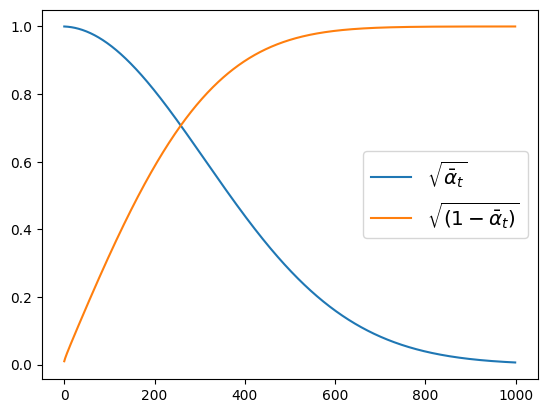

In [9]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**Exercise:** You can explore how this plot changes with different settings for beta_start, beta_end and beta_schedule by swapping in one of the commented-out options here:

In [10]:
# One with too little noise added:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

Whichever scheduler you've chosen, we can now use it to add noise in different amounts using the `noise_scheduler.add_noise` function like so:

In [11]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
xb = xb.float()
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
#show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

Noisy X shape torch.Size([8, 1, 32, 32])


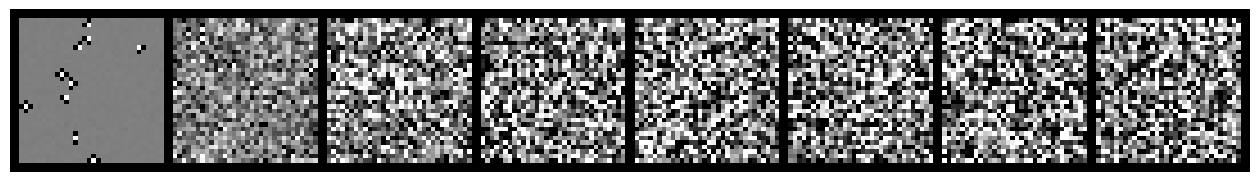

In [12]:
import matplotlib.pyplot as plt
import torchvision

# Rescale from [-1, 1] to [0, 1]
def visualize_noised_samples(noised_xb):
    noised_xb = (noised_xb + 1) / 2  # Rescale to [0, 1]
    noised_xb = noised_xb.clamp(0, 1)  # Ensure valid range for display
    noised_xb = noised_xb.cpu()  # Move to CPU if on GPU

    # Create a grid of images
    grid = torchvision.utils.make_grid(noised_xb, nrow=8)  # Arrange 8 samples in a row
    np_img = grid.permute(1, 2, 0).numpy()  # Convert to (H, W, C) for matplotlib

    # Plot the images
    plt.figure(figsize=(16, 8))
    plt.imshow(np_img)
    plt.axis("off")
    plt.show()

# Call the function to visualize
visualize_noised_samples(noisy_xb)


Again, explore the effect of using different noise schedules and parameters here. [This video](https://www.youtube.com/watch?v=fbLgFrlTnGU) does a great job explaining some of the maths above in more detail, and is a great introduction to some of these concepts.

## Step 4: Define the Model

Now we come to the core component: the model itself.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers, each of which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size.
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):

In [13]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage. We'll talk later about how you might experiment to find the best settings for your use-case.

We can check that passing in a batch of data and some random timesteps produces an output the same shape as the input data:

In [14]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 1, 32, 32])

In the next section we'll see how to train this model.

## Step 5: Create a Training Loop

Time to train! Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer - in this case the AdamW optimizer with a learning rate of 0.0004.

For each batch of data, we
- Sample some random timesteps
- Noise the data accordingly
- Feed the noisy data through the model
- Compare the model predictions with the target (i.e. the noise in this case) using mean squared error as our loss function
- Update the model parameters via `loss.backward()` and `optimizer.step()`

During this process we also log the losses over time for later plotting.

NB: This code takes nearly 10 minutes to run - feel free to skip these two cells and use the pretrained model if you are in a hurry. Alternatively, you can explore how reducing the number of channels in each layer via the model definition above can speed things up.

The [official diffusers training example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) trains a larger model on this dataset at higher resolution, and is a good reference for what a less minimal training loop looks like:

In [15]:
from torch.nn import functional as F

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        # Move clean images to the correct device
        clean_images = batch["images"].to(device).float()

        # Sample noise and timesteps
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)

        # Zero gradients, backpropagate, and update model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log the loss
        losses.append(loss.item())

    # Log the average loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch:5, loss: 0.033800930809229614
Epoch:10, loss: 0.026959038339555264
Epoch:15, loss: 0.024174899468198417
Epoch:20, loss: 0.022550026839599013
Epoch:25, loss: 0.021933485567569733
Epoch:30, loss: 0.022044007293879987


Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate (which is more obvious if we use a log scale as shown on the right):

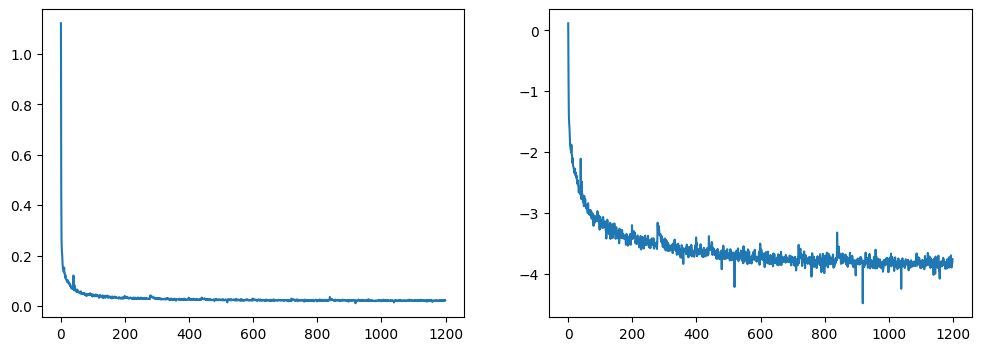

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

As an alternative to running the training code above, you can use the model from the pipeline like so:

In [17]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

## Step 6: Generate Images

How do we get images with this model?

### Option 1: Creating a pipeline:

In [18]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Run the pipeline to generate images
pipeline_output = image_pipe()

# Access the first image
generated_image_pil = pipeline_output.images[0]  # PIL image

# Convert to NumPy array
generated_image_np = np.array(generated_image_pil)

# Check the shape and dtype
print("NumPy array shape:", generated_image_np.shape)
print("NumPy array dtype:", generated_image_np.dtype)


  0%|          | 0/1000 [00:00<?, ?it/s]

NumPy array shape: (32, 32)
NumPy array dtype: uint8


  0%|          | 0/1000 [00:00<?, ?it/s]

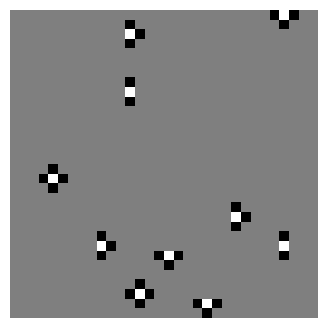

In [20]:
import torch
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

def visualize_pipeline_output(pipeline_output, nrow=8):
    """
    Visualizes images generated by the DDPMPipeline in a grid format.
    Args:
        pipeline_output: The output from the DDPMPipeline, expected to contain PIL images.
        nrow: Number of images per row in the grid.
    """
    # Convert PIL images to tensors
    tensors = [ToTensor()(image) for image in pipeline_output.images]  # Converts to [0, 1]

    # Stack tensors into a batch and rescale to [-1, 1] if needed
    image_batch = torch.stack(tensors) * 2 - 1  # Rescale from [0, 1] to [-1, 1]

    # Clamp to ensure values are in [-1, 1]
    image_batch = image_batch.clamp(-1, 1)

    # Rescale from [-1, 1] to [0, 1] for visualization
    image_batch = (image_batch + 1) / 2
    image_batch = image_batch.clamp(0, 1)

    # Apply thresholding
    image_batch = torch.where(image_batch < 0.25, torch.zeros_like(image_batch), image_batch)  # Set < 0.25 to 0
    image_batch = torch.where(image_batch > 0.75, torch.ones_like(image_batch), image_batch)   # Set > 0.75 to 1
    image_batch = torch.where((image_batch >= 0.25) & (image_batch <= 0.75), torch.full_like(image_batch, 0.5), image_batch)  # Set [0.25, 0.75] to 0.5

    # Create a grid of images
    grid = torchvision.utils.make_grid(image_batch, nrow=nrow)
    np_img = grid.permute(1, 2, 0).numpy()  # Convert to (H, W, C) for matplotlib

    # Plot the images
    plt.figure(figsize=(4, 4))
    plt.imshow(np_img)
    plt.axis("off")
    plt.show()

# Run the pipeline to generate images
pipeline_output = image_pipe()

# Visualize the output
visualize_pipeline_output(pipeline_output)


We can save a pipeline to a local folder like so:

In [21]:
image_pipe.save_pretrained("my_pipeline")

Inspecting the folder contents:

In [22]:
!ls my_pipeline/

model_index.json  scheduler  unet


The `scheduler` and `unet` subfolders contain everything needed to re-create those components. For example, inside the `unet` folder you'll find the model weights (`diffusion_pytorch_model.bin`) alongside a config file which specifies the UNet architecture.

In [23]:
!ls my_pipeline/unet/

config.json  diffusion_pytorch_model.safetensors


Together, these files contain everything needed to recreate the pipeline. You can manually upload them to the hub to share the pipeline with others, or check out the code to do this via the API in the next section.